# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
- Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
- Answer the previous question aggregating the data by (c) country and (d) region.

Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.


In [32]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Match universities together
from difflib import SequenceMatcher
import re


# www.topuniversities.com

In [33]:
r=requests.get("https://www.topuniversities.com/university-rankings/world-university-rankings/2018")
soup=BeautifulSoup(r.text,'html.parser')
# Uncomment to see where we got the url
# print(soup.prettify())

As we can see in the JQuery, the ranking table is loaded from :
https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt

In [34]:
# Get the ranking
r=requests.get("https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt")
ranking_json=r.json()
r.status_code

200

Now we scrap the data, from the json we got from the website and by going to each of the university detail page.  

Interesting to note that NYC doesn't have any data on its number of students nor on its faculty staff.  

As there is a typo in the ranking at 199, we take the universities until rank equal to 201, in order to get the first 200 universities.  

Moreover, note that for Bangalore IISC, we assume that there is no international faculty member because there is no data in this field. 


In [35]:
# First 200 universities
universities_dict=[]
# For all universities, we extract the infos
for json_uni in ranking_json['data'] :
    my_uni=dict()
    my_uni['name']=json_uni['title']
    my_uni['country']=json_uni['country']
    my_uni['region']=json_uni['region']
    # If the rank is of the form =20, we remove the '='
    if(json_uni['rank_display'][0]=='='):
        my_uni['rank']=int(json_uni['rank_display'][1:])
    else:
        my_uni['rank']=int(json_uni['rank_display'])
    my_uni['detail_page']="https://www.topuniversities.com"+json_uni['url']
    
    # Finding faculty members and students:
    # Get the detail page
    request_details=requests.get(my_uni['detail_page'])
    soup_detail=BeautifulSoup(request_details.text,'html.parser')
    
    # Find the faculty staff part
    faculty_soup=soup_detail.find_all(name='div',class_="faculty-main wrapper col-md-4 item active")
    if len(faculty_soup)==0:
        total_faculty_members=None
        int_faculty_members=None
    else:
        assert len(faculty_soup)==1
        # Find the total number of staff
        total_faculty_members_soup=faculty_soup[0].find_all('div',class_="total faculty")
        if len(total_faculty_members_soup)==0:
            total_faculty_members=None
        else:
            assert(len(total_faculty_members_soup)==1)
            total_faculty_members_text=total_faculty_members_soup[0].find_all('div',class_="number")[0].text
            total_faculty_members=int(total_faculty_members_text.strip().replace(',',''))
        # Find the international staff
        int_faculty_members_soup=faculty_soup[0].find_all('div',class_="inter faculty")
        if (len(int_faculty_members_soup)==0):
            int_faculty_members=None
        else:
            assert(len(int_faculty_members_soup)==1)
            int_faculty_members_text=int_faculty_members_soup[0].find_all('div',class_="number")[0].text
            int_faculty_members=int(int_faculty_members_text.strip().replace(',',''))
    
    # Find the total number of students
    total_students_soup=soup_detail.find_all(name='div',class_="students-main wrapper col-md-4 item")
    if len(total_students_soup)==0:
        total_students=None
    else:        
        assert len(total_students_soup)==1
        total_students_soup=total_students_soup[0].find_all('div',class_="total student")
        assert(len(total_students_soup)==1)
        total_students_text=total_students_soup[0].find_all('div',class_="number")[0].text
        total_students=int(total_students_text.strip().replace(',',''))

    # find the number of international number of studens
    int_students_soup=soup_detail.find_all(name='div',class_="int-students-main wrapper col-md-4 item")
    if len(int_students_soup)==0:
        int_students=0
    else:
        assert len(int_students_soup)==1
        int_students_soup=int_students_soup[0].find_all('div',class_="total inter")
        assert(len(int_students_soup)==1)
        int_students_text=int_students_soup[0].find_all('div',class_="number")[0].text
        int_students=int(int_students_text.strip().replace(',',''))
    
    my_uni['Total faculty members']=total_faculty_members
    my_uni['International faculty members']=int_faculty_members
    my_uni['Total students']=total_students
    my_uni['International students']=int_students
    
    
    universities_dict.append(my_uni)
    
    # We only want the top 200
    if (my_uni['rank']>200):
        break

We create the Dataframe

In [36]:
df = pd.DataFrame(universities_dict)
df['original rank'] = df['rank']
df['rank'] = df.index + 1

df.to_csv('topuniversities.csv', encoding='utf-8')

### Load datasets

In [37]:
df = pd.read_csv('topuniversities.csv', encoding='utf-8', index_col=0)
df

,International faculty members,International students,Total faculty members,Total students,country,detail_page,name,rank,region,original rank
0,1679.0,3717,2982.0,11067.0,United States,https://www.topuniversities.com/universities/m...,Massachusetts Institute of Technology (MIT),1,North America,1
1,2042.0,3611,4285.0,15878.0,United States,https://www.topuniversities.com/universities/s...,Stanford University,2,North America,2
2,1311.0,5266,4350.0,22429.0,United States,https://www.topuniversities.com/universities/h...,Harvard University,3,North America,3
3,350.0,647,953.0,2255.0,United States,https://www.topuniversities.com/universities/c...,California Institute of Technology (Caltech),4,North America,4
4,2278.0,6699,5490.0,18770.0,United Kingdom,https://www.topuniversities.com/universities/u...,University of Cambridge,5,Europe,5
5,2964.0,7353,6750.0,19720.0,United Kingdom,https://www.topuniversities.com/universities/u...,University of Oxford,6,Europe,6
6,2554.0,14854,6345.0,31080.0,United Kingdom,https://www.topuniversities.com/universities/u...,UCL (University College London),7,Europe,7
7,2071.0,8746,3930.0,16090.0,United Kingdom,https://www.topuniversities.com/universities/i...,Imperial College London,8,Europe,8
8,635.0,3379,2449.0,13557.0,United States,https://www.topuniversities.com/universities/u...,University of Chicago,9,North America,9
9,1886.0,7563,2477.0,19815.0,Switzerland,https://www.topuniversities.com/universities/e...,ETH Zurich - Swiss Federal Institute of Techno...,10,Europe,10


### Ratio between faculty members and students and international students by universities

We compute the ratio and sort by it.

In [38]:
df['Ratio faculty members/students']=df['Total faculty members']/df['Total students']
df['Ratio international students']=df['International students']/df['Total students']
df_sorted_by_ratio_fac_stud=df.sort(columns='Ratio faculty members/students', ascending=False)
df_sorted_by_ratio_international_students=df.sort(columns='Ratio international students', ascending=False)

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


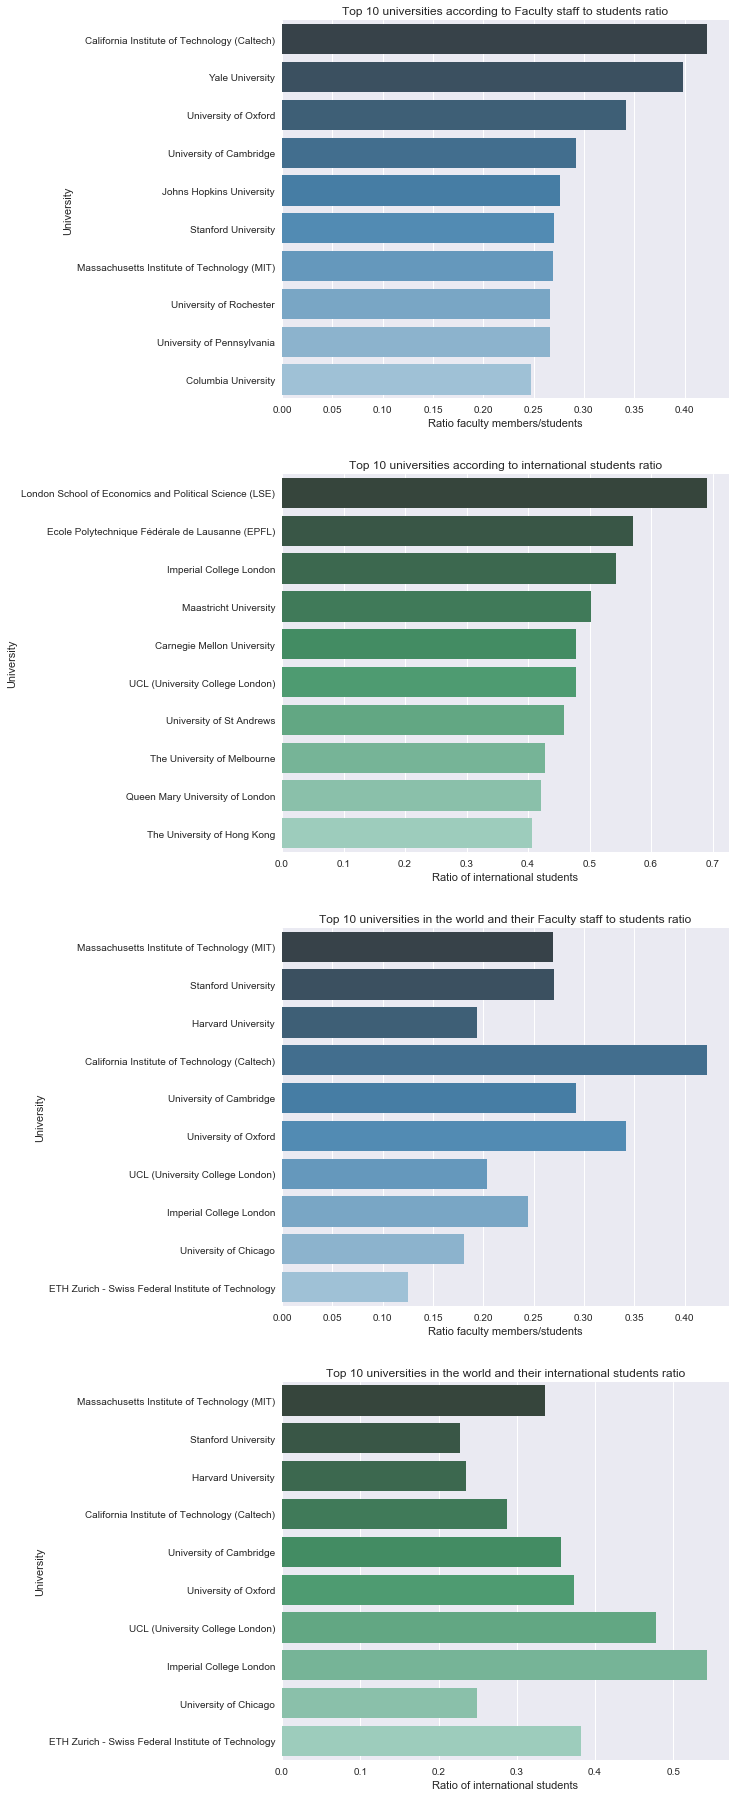

In [39]:
# Set up the matplotlib figure
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1,figsize=(8,32))

sns.barplot(x=df_sorted_by_ratio_fac_stud[:10]['Ratio faculty members/students'],
            y=df_sorted_by_ratio_fac_stud[:10]['name'],palette="Blues_d",ax=ax1)
ax1.set_title("Top 10 universities according to Faculty staff to students ratio")
ax1.set_ylabel("University")
ax1.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_sorted_by_ratio_international_students[:10]['Ratio international students'],
            y=df_sorted_by_ratio_international_students[:10]['name'],palette="BuGn_d",ax=ax2)
ax2.set_title("Top 10 universities according to international students ratio")
ax2.set_ylabel("University")
ax2.set_xlabel("Ratio of international students")

sns.barplot(x=df[:10]['Ratio faculty members/students'],
            y=df[:10]['name'],palette="Blues_d",ax=ax3)
ax3.set_title("Top 10 universities in the world and their Faculty staff to students ratio")
ax3.set_ylabel("University")
ax3.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df[:10]['Ratio international students'],
            y=df[:10]['name'],palette="BuGn_d",ax=ax4)
ax4.set_title("Top 10 universities in the world and their international students ratio")
ax4.set_ylabel("University")
ax4.set_xlabel("Ratio of international students")
plt.show()

As we can see, most of the top 10 universities in the world are also the universities with the highest faculty staff/student ratio. So we could think that indeed having a high faculty staff to students ratio is good

The top 10 most international universities are also quite international, but are not the most international ones.

### Ratio between faculty members and students and international students by country

Here we will keep only the country, the name of the uni (for the index) and the ratios. 

We then aggregate to the countries by meaning the ratios, so that we get the average ratio of a country (both for faculty staff/student and international/national students)

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


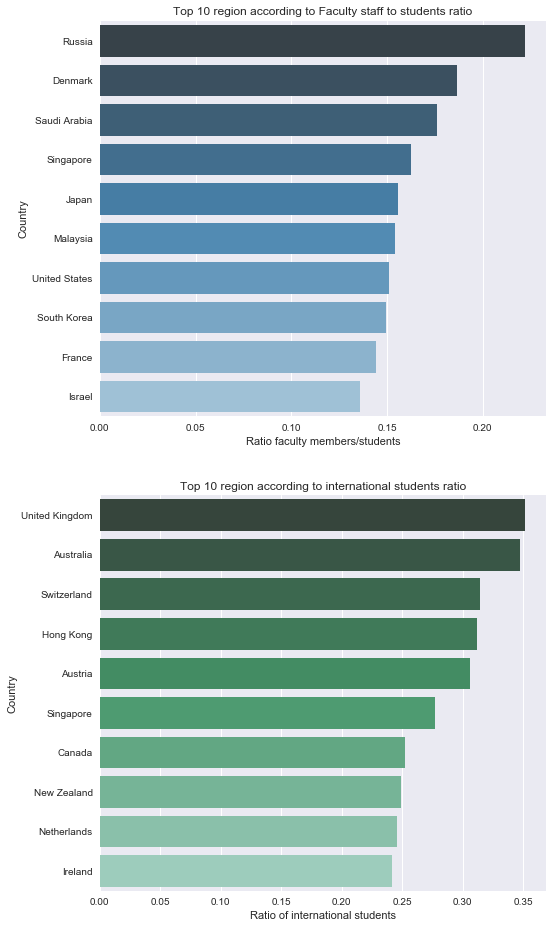

In [40]:

df_by_region=df.set_index(['country','name'])[['Ratio faculty members/students','Ratio international students']]
df_by_region=df_by_region.mean(level='country')
df_by_region=df_by_region.reset_index()
df_by_region_faculty_student_ratio = df_by_region.sort('Ratio faculty members/students',ascending=False)
df_by_region_international_student_ratio = df_by_region.sort('Ratio international students',ascending=False)

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,16))
sns.barplot(x=df_by_region_faculty_student_ratio[:10]['Ratio faculty members/students'],
            y=df_by_region_faculty_student_ratio[:10]['country'],palette="Blues_d",ax=ax1)
ax1.set_title("Top 10 region according to Faculty staff to students ratio")
ax1.set_ylabel("Country")
ax1.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_by_region_international_student_ratio[:10]['Ratio international students'],
            y=df_by_region_international_student_ratio[:10]['country'],palette="BuGn_d",ax=ax2)
ax2.set_title("Top 10 region according to international students ratio")
ax2.set_ylabel("Country")
ax2.set_xlabel("Ratio of international students")

plt.show()

Russia is the country with the most faculty staff for students, even though it has no universitites in the top 10 of the highest ratio staff/students.

The UK is the most international country and we can also see it in the top 10 most international universities, where 6 of them are in UK.

### Ratio between faculty members and students and international students by Region

We do exactly the same but with regions

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


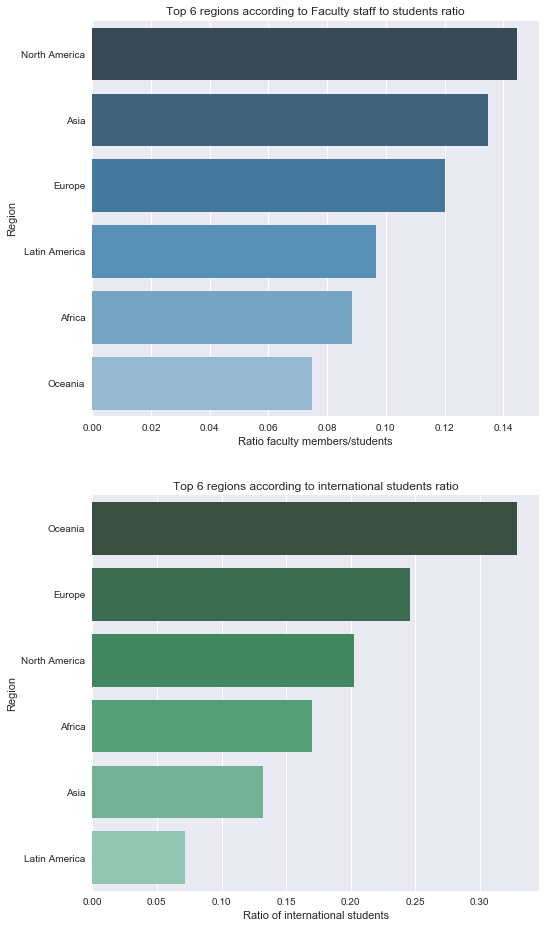

In [41]:
df_by_region=df.set_index(['region','name'])[['Ratio faculty members/students','Ratio international students']]
df_by_region=df_by_region.mean(level='region')
df_by_region=df_by_region.reset_index()
df_by_region_faculty_student_ratio = df_by_region.sort('Ratio faculty members/students',ascending=False)
df_by_region_international_student_ratio = df_by_region.sort('Ratio international students',ascending=False)

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,16))
sns.barplot(x=df_by_region_faculty_student_ratio['Ratio faculty members/students'],
            y=df_by_region_faculty_student_ratio['region'],palette="Blues_d",ax=ax1)
ax1.set_title("Top 6 regions according to Faculty staff to students ratio")
ax1.set_ylabel("Region")
ax1.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_by_region_international_student_ratio['Ratio international students'],
            y=df_by_region_international_student_ratio['region'],palette="BuGn_d",ax=ax2)
ax2.set_title("Top 6 regions according to international students ratio")
ax2.set_ylabel("Region")
ax2.set_xlabel("Ratio of international students")

plt.show()

North America have the most faculty staff per students and Oceania is the most international Region.

# www.timeshighereducation.com

In [42]:
r = requests.get("https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/-1/sort_by/rank/sort_order/asc/cols/stats")
soup=BeautifulSoup(r.text,'html.parser')
# Uncomment to see where we got the url
# print(soup.prettify())

As we can see, the data is loaded from :

https://www.timeshighereducation.com//sites//default//files//the_data_rankings//world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json

In [43]:
r=requests.get("https://www.timeshighereducation.com//sites//default//files//the_data_rankings//world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")
ranking_json = r.json()

We don't have the region in the times, so we will get them from our previous dataframe

In [44]:
df_regions= df[['country','region']].drop_duplicates()
df_regions = df_regions.set_index('country')['region']

In [45]:
# First 200 universities
universities_dict=[]
# For all universities, we extract the infos
for json_uni in ranking_json['data'] :
    my_uni=dict()
    my_uni['name']=json_uni['name']
    my_uni['country']=json_uni['location']
    if my_uni['country'] == 'Luxembourg':
        my_uni['region']='Europe'
    elif(my_uni['country']=='Russian Federation'):
        my_uni['country']='Russia'
        my_uni['region']='Europe'
    else:
        my_uni['region']=df_regions[my_uni['country']]
        
    # If the rank is of the form =20, we remove the '='
    try:
        if(json_uni['rank'][0]=='='):
            my_uni['rank']=int(json_uni['rank'][1:])
        else:
            my_uni['rank']=int(json_uni['rank'])
    except ValueError:
        # We have 201-250 from now on
        break
    
    my_uni['Ratio international students']=float(json_uni['stats_pc_intl_students'][:-1])/100 # It's a percentage
    my_uni['Ratio faculty members/students']=1/float(json_uni['stats_student_staff_ratio'])  
    
    universities_dict.append(my_uni)
    # We only want the top 200
    if (my_uni['rank']>=200):
        break


In [46]:
df_times=pd.DataFrame(universities_dict)
df_times['original rank'] = df_times['rank']
df_times['rank'] = df_times.index + 1
df_times.to_csv('timeshighereducation.csv', encoding='utf-8')

### Load datasets

In [47]:
df_times = pd.read_csv('timeshighereducation.csv', encoding='utf-8', index_col=0)
df_times

,Ratio faculty members/students,Ratio international students,country,name,rank,region,original rank
0,0.089286,0.38,United Kingdom,University of Oxford,1,Europe,1
1,0.091743,0.35,United Kingdom,University of Cambridge,2,Europe,2
2,0.153846,0.27,United States,California Institute of Technology,3,North America,3
3,0.133333,0.22,United States,Stanford University,4,North America,3
4,0.114943,0.34,United States,Massachusetts Institute of Technology,5,North America,5
5,0.112360,0.26,United States,Harvard University,6,North America,6
6,0.120482,0.24,United States,Princeton University,7,North America,7
7,0.087719,0.55,United Kingdom,Imperial College London,8,Europe,8
8,0.161290,0.25,United States,University of Chicago,9,North America,9
9,0.068493,0.38,Switzerland,ETH Zurich – Swiss Federal Institute of Techno...,10,Europe,10


### Ratio between faculty members and students and international students by universities

We compute the ratio and sort by it.

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


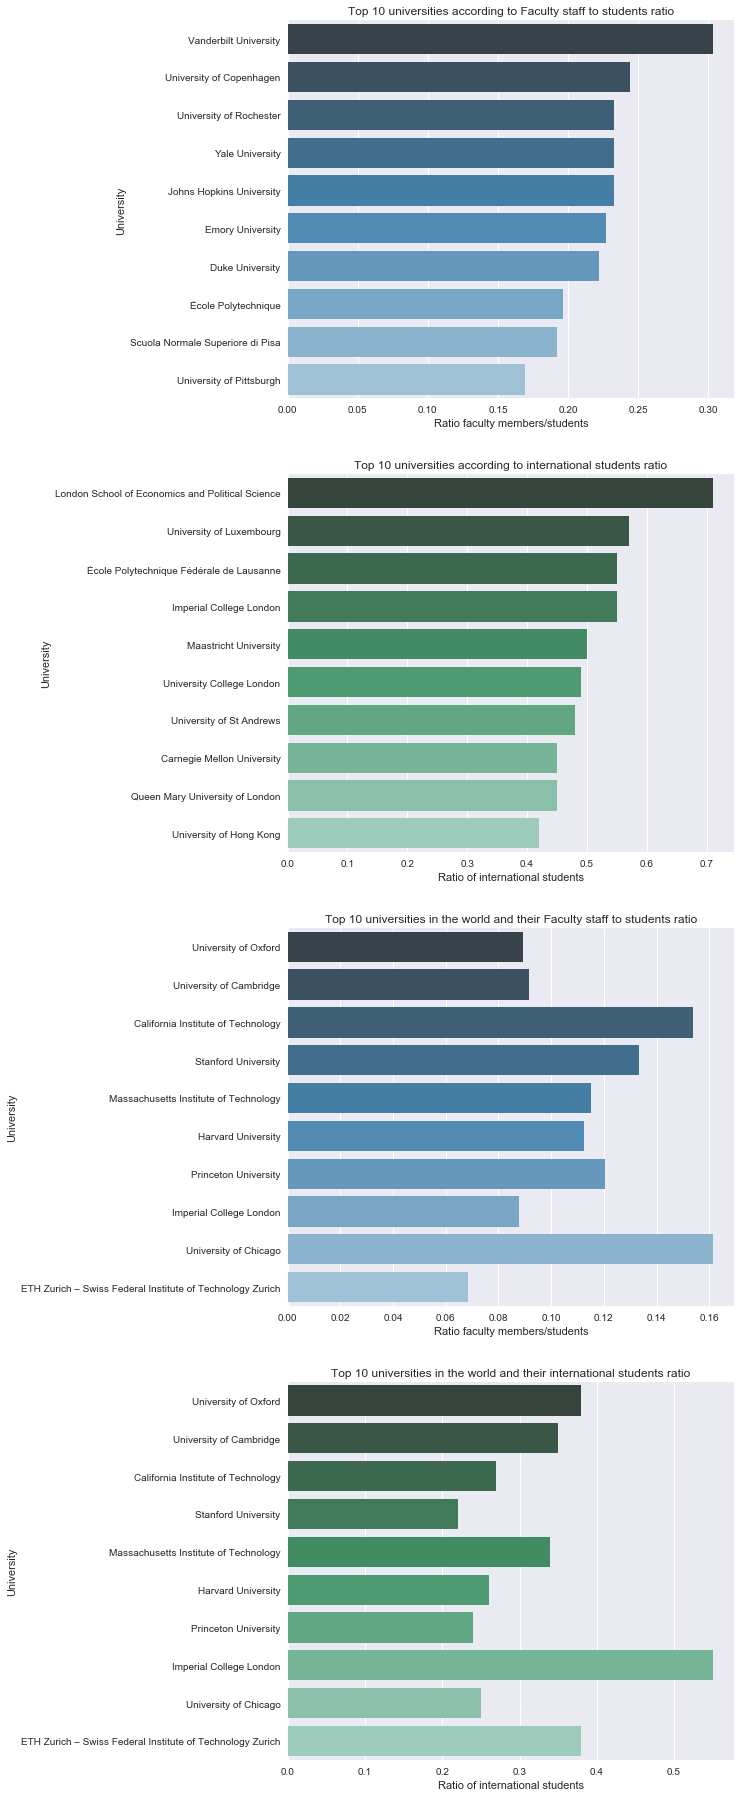

In [48]:
df_sorted_by_ratio_fac_stud=df_times.sort(columns='Ratio faculty members/students', ascending=False)
df_sorted_by_ratio_international_students=df_times.sort(columns='Ratio international students', ascending=False)

# Set up the matplotlib figure
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1,figsize=(8,32))

sns.barplot(x=df_sorted_by_ratio_fac_stud[:10]['Ratio faculty members/students'],
            y=df_sorted_by_ratio_fac_stud[:10]['name'],palette="Blues_d",ax=ax1)
ax1.set_title("Top 10 universities according to Faculty staff to students ratio")
ax1.set_ylabel("University")
ax1.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_sorted_by_ratio_international_students[:10]['Ratio international students'],
            y=df_sorted_by_ratio_international_students[:10]['name'],palette="BuGn_d",ax=ax2)
ax2.set_title("Top 10 universities according to international students ratio")
ax2.set_ylabel("University")
ax2.set_xlabel("Ratio of international students")

sns.barplot(x=df_times[:10]['Ratio faculty members/students'],
            y=df_times[:10]['name'],palette="Blues_d",ax=ax3)
ax3.set_title("Top 10 universities in the world and their Faculty staff to students ratio")
ax3.set_ylabel("University")
ax3.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_times[:10]['Ratio international students'],
            y=df_times[:10]['name'],palette="BuGn_d",ax=ax4)
ax4.set_title("Top 10 universities in the world and their international students ratio")
ax4.set_ylabel("University")
ax4.set_xlabel("Ratio of international students")
plt.show()

Here we have different results than from topuniversities.com 

### Ratio between faculty members and students and international students by country

Here we will keep only the country, the name of the uni (for the index) and the ratios. 

We then aggregate to the countries by meaning the ratios, so that we get the average ratio of a country (both for faculty staff/student and international/national students)

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


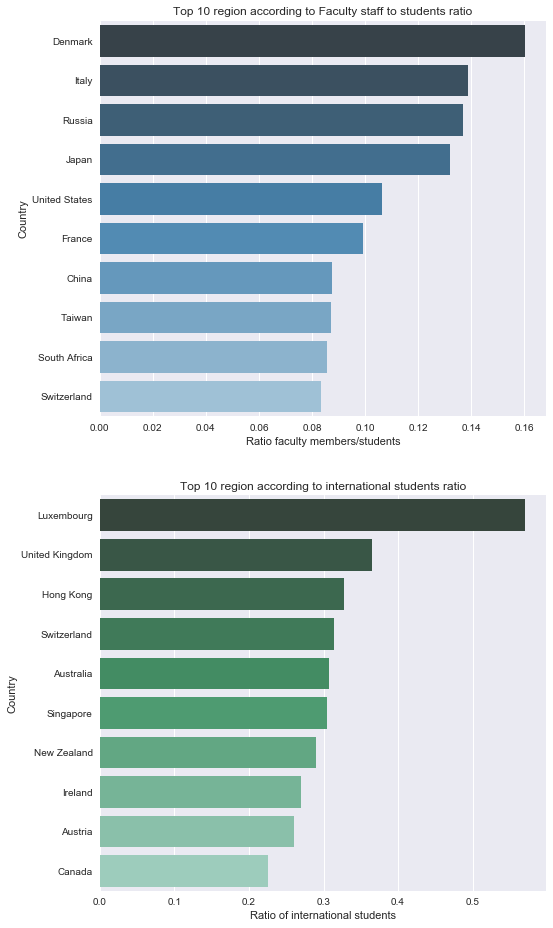

In [49]:
df_by_region=df_times.set_index(['country','name'])[['Ratio faculty members/students','Ratio international students']]
df_by_region=df_by_region.mean(level='country')
df_by_region=df_by_region.reset_index()
df_by_region_faculty_student_ratio = df_by_region.sort('Ratio faculty members/students',ascending=False)
df_by_region_international_student_ratio = df_by_region.sort('Ratio international students',ascending=False)

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,16))
sns.barplot(x=df_by_region_faculty_student_ratio[:10]['Ratio faculty members/students'],
            y=df_by_region_faculty_student_ratio[:10]['country'],palette="Blues_d",ax=ax1)
ax1.set_title("Top 10 region according to Faculty staff to students ratio")
ax1.set_ylabel("Country")
ax1.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_by_region_international_student_ratio[:10]['Ratio international students'],
            y=df_by_region_international_student_ratio[:10]['country'],palette="BuGn_d",ax=ax2)
ax2.set_title("Top 10 region according to international students ratio")
ax2.set_ylabel("Country")
ax2.set_xlabel("Ratio of international students")

plt.show()

Here we can see that denmark is at the top, followed by Russia, which is similar than before.

However for international students, Luxembourg is at the top, but it wasn't present in the other chart.

### Ratio between faculty members and students and international students by Region

We do exactly the same but with regions

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


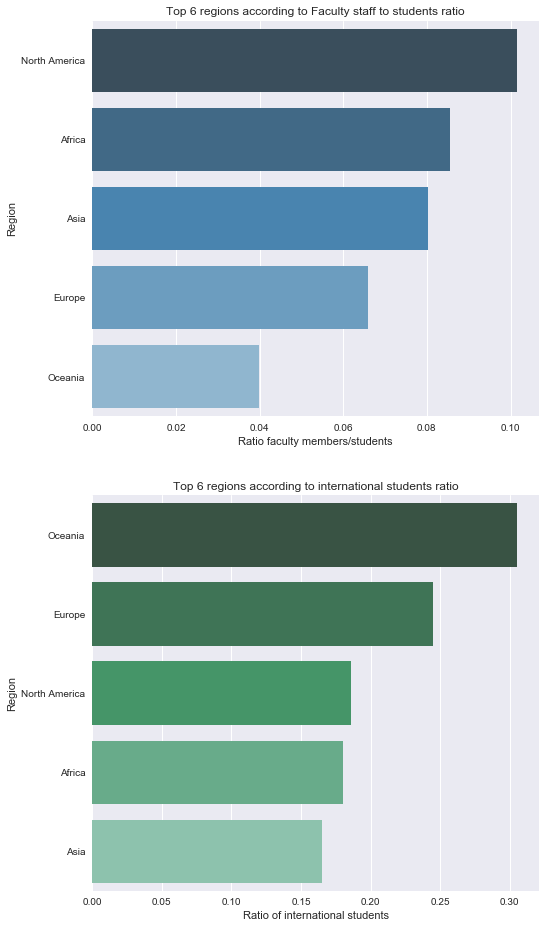

In [50]:
df_by_region=df_times.set_index(['region','name'])[['Ratio faculty members/students','Ratio international students']]
df_by_region=df_by_region.mean(level='region')
df_by_region=df_by_region.reset_index()
df_by_region_faculty_student_ratio = df_by_region.sort('Ratio faculty members/students',ascending=False)
df_by_region_international_student_ratio = df_by_region.sort('Ratio international students',ascending=False)

f, (ax1, ax2) = plt.subplots(2, 1,figsize=(8,16))
sns.barplot(x=df_by_region_faculty_student_ratio['Ratio faculty members/students'],
            y=df_by_region_faculty_student_ratio['region'],palette="Blues_d",ax=ax1)
ax1.set_title("Top 6 regions according to Faculty staff to students ratio")
ax1.set_ylabel("Region")
ax1.set_xlabel("Ratio faculty members/students")

sns.barplot(x=df_by_region_international_student_ratio['Ratio international students'],
            y=df_by_region_international_student_ratio['region'],palette="BuGn_d",ax=ax2)
ax2.set_title("Top 6 regions according to international students ratio")
ax2.set_ylabel("Region")
ax2.set_xlabel("Ratio of international students")

plt.show()

Africa took two places finishing second whereas it was fourth on the previous website. 

The international ratio by regions is nearly the same as the first website

# Merging the two Dataframes

What we need to focus on here is to be able find common university between the two rankings. Since they do not have all the same terminology, we will use a sequence matcher function from `difflib` in order to find a ratio of matching string.

We will also make sure to translate some words that often come in an other language such as "Universität".
We proceed in tweaking the ratio limit of matching sequences. 
Finally we add to the replace dictionary, the few names that are remaining, so all the universities that can be matched are matched. 
We check the remaining by sorting by country and number of students.  
For the Belgium universities, the 'Université libre de Bruxelles' and 'Vrije Universiteit Brussel' are not the same even though their translation match. 


In [51]:
replaceDict = {
    "UniversitatAutònomadeBarcelona" : "AutonomousUniversityofBarcelona",
    "WageningenUniversity" : "WageningenUniversity&Research",
    "ScuolaSuperioreSant'AnnaPisadiStudiUniversitariediPerfezionamento" : "ScuolaSuperioreSant’Anna",
    "TrinityCollegeDublin,TheUniversityofDublin": "TrinityCollegeDublin",
    "Ruprecht-Karls-UniversitätHeidelberg" : "HeidelbergUniversity",
    "UniversitéPierreetMarieCurie" : "PierreandMarieCurieUniversity",
    "EberhardKarlsUniversitätTübingen" : "UniversityofTübingen",
    "Albert-Ludwigs-UniversitaetFreiburg" : "UniversityOfFreiburg",
    "Ludwig-Maximilians-Universität" : "LMU",
    "Université" : "University",
    "Universitaet" : "University",
    "Universität" : "University",
    "München" : "Munich",
    "Freie" : "Free",
    "Technische" : "Technical",
    "Montréal" : "Montreal",
}

def findBestMatch(name, country, nameList):
    """Finds the best match for the university name inside the other dataframe list of names"""
    ratio = 0
    result = ''
    for country2, name2 in nameList.itertuples(index=False):
        if str(country2) == str(country):
            foundRatio = float(SequenceMatcher(None, name, name2).ratio())
            if(foundRatio > ratio):
                ratio = foundRatio
                result = name2
    return(result, ratio)

def removeParenthesisContentAndSpaces(text):
    return re.sub("\s+", '', re.sub(r'\([^)]*\)', '', text))

In [52]:
dfTimes = df_times.copy()
dfTopuni = df.copy()
# Clean the names
dfTimes['name_'] = dfTimes['name'].apply(removeParenthesisContentAndSpaces)
dfTopuni['name_'] = dfTopuni['name'].apply(removeParenthesisContentAndSpaces)
dfTimes['name_'] = dfTimes['name_'].replace(replaceDict, regex=True)
dfTopuni['name_'] = dfTopuni['name_'].replace(replaceDict, regex=True)

# Init variables
limitRatio = 0.87
verbose = 0
associatedNameList = []
ratioList = []

# Create the list of names, if the names are similar enough in the two rankings, we use a common one
for nameTimes in dfTimes['name_']:
    countryTimes = dfTimes[dfTimes['name_']==nameTimes]['country'].values[0]
    found, ratio = findBestMatch(nameTimes, countryTimes, dfTopuni[['country', 'name_']])
    if(ratio < 1 and ratio > limitRatio):
        if(verbose):
            print(nameTimes, found, ratio)
    if(ratio > limitRatio):
        associatedNameList.append(found)
        ratioList.append(ratio)
    else:
        associatedNameList.append(nameTimes)
        ratioList.append(ratio)
        
# Add one column with common names
dfTimes['times_matchName'] = associatedNameList

# Arrange the dataframes
dfTopuni=dfTopuni.rename(columns={'rank':'rank topuni',
                                                      'Ratio faculty members/students':'Ratio faculty members/students topuni',
                                                      'Ratio international students':'Ratio international students topuni'})
dfTopuni=dfTopuni.drop(['detail_page','International faculty members','International students','Total faculty members','Total students'],axis=1)

dfTimes=dfTimes.rename(columns={'rank':'rank times',
                                                    'Ratio faculty members/students':'Ratio faculty members/students times',
                                                    'Ratio international students':'Ratio international students times'})

# Merge the two dataframe by taking the intersection of common names, i.e. drop NaN names
df_merged = dfTimes.merge(dfTopuni, left_on='times_matchName', right_on='name_', how='inner')
df_merged=df_merged.drop(['name__x', 'name__y', 'name_x', 'times_matchName'], axis=1)
df_merged = df_merged.rename(columns={'name_y':'name'})
df_merged = df_merged.set_index(['name'])
print(df_merged.shape)

(159, 12)


We manage to find 156 common universities using our approach. By just simply merging equal names, we would have had around 114 common universities so we would have lost information. We now have a look at the data we just merged.

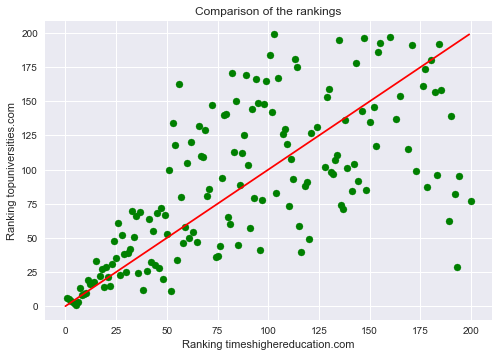

In [53]:
plt.scatter(df_merged['rank times'],df_merged['rank topuni'],color='green')
plt.plot(range(200),range(200),color='red')
plt.ylabel("Ranking topuniversities.com")
plt.xlabel("Ranking timeshighereducation.com")
plt.title("Comparison of the rankings")
plt.show()

As we can see, they are quite similar for the first rankings

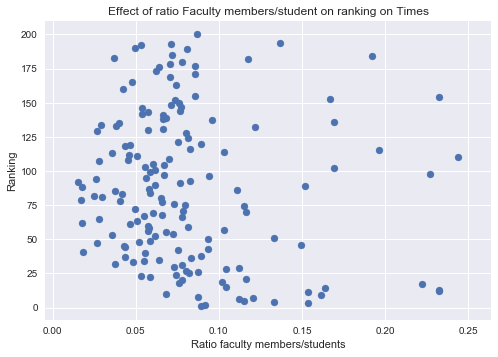

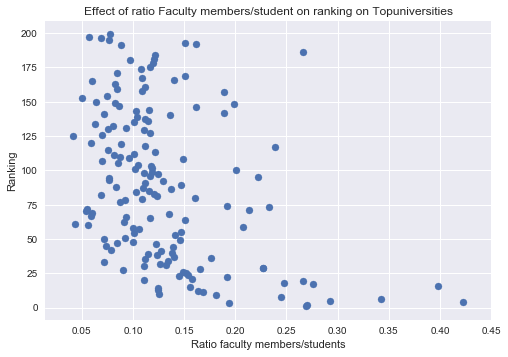

In [54]:
plt.scatter( df_merged['Ratio faculty members/students times'],df_merged['rank times'],)
plt.ylabel("Ranking")
plt.xlabel("Ratio faculty members/students")
plt.title("Effect of ratio Faculty members/student on ranking on Times")
plt.show()

plt.scatter( df_merged['Ratio faculty members/students topuni'],df_merged['rank topuni'])
plt.ylabel("Ranking")
plt.xlabel("Ratio faculty members/students")
plt.title("Effect of ratio Faculty members/student on ranking on Topuniversities")
plt.show()




It seems  that the highest Staff/student ratio universities are usually good universities according to topuniversities.com. It is less clear with timeshighereducation.com

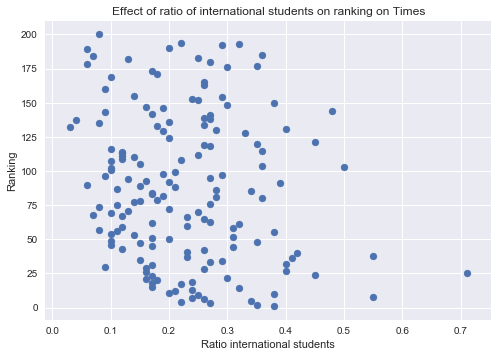

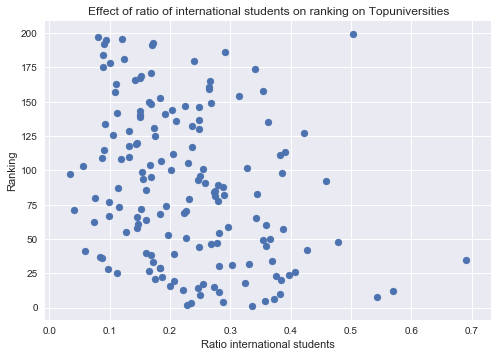

In [55]:
plt.scatter( df_merged['Ratio international students times'],df_merged['rank times'],)
plt.ylabel("Ranking")
plt.xlabel("Ratio international students")
plt.title("Effect of ratio of international students on ranking on Times")
plt.show()

plt.scatter( df_merged['Ratio international students topuni'],df_merged['rank topuni'])
plt.ylabel("Ranking")
plt.xlabel("Ratio international students")
plt.title("Effect of ratio of international students on ranking on Topuniversities")
plt.show()

There doesn't seem to be any remarqueble patterns, except that the most international university usually have a good ranking

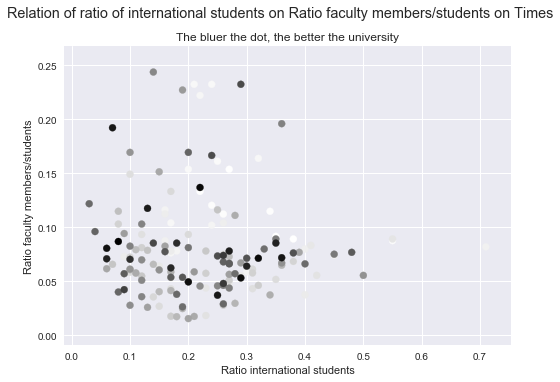

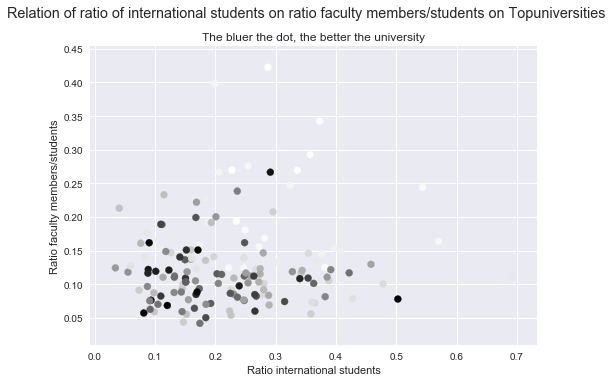

In [56]:
plt.scatter( df_merged['Ratio international students times'],df_merged['Ratio faculty members/students times'],c=df_merged['rank times'])
plt.ylabel("Ratio faculty members/students")
plt.xlabel("Ratio international students")
plt.suptitle("Relation of ratio of international students on Ratio faculty members/students on Times")
plt.title("The bluer the dot, the better the university")
plt.show()

plt.scatter( df_merged['Ratio international students topuni'],df_merged['Ratio faculty members/students topuni'],c=df_merged['rank topuni'])
plt.ylabel("Ratio faculty members/students")
plt.xlabel("Ratio international students")
plt.suptitle("Relation of ratio of international students on ratio faculty members/students on Topuniversities")
plt.title("The bluer the dot, the better the university")
plt.show()

A pattern that seems to emerge is that an university can either be very international OR have a lot of staff for its students.

Also the best universities have usually a lot of staff members per student and a lot of international students


In [57]:
df_merged.corr()

,Ratio faculty members/students times,Ratio international students times,rank times,original rank_x,rank topuni,original rank_y,Ratio faculty members/students topuni,Ratio international students topuni
Ratio faculty members/students times,1.000000,-0.031814,-0.114863,-0.115979,-0.214222,-0.213937,0.695415,-0.070692
Ratio international students times,-0.031814,1.000000,-0.170518,-0.169542,-0.300356,-0.299557,0.124392,0.948449
rank times,-0.114863,-0.170518,1.000000,0.999959,0.666502,0.665419,-0.271313,-0.208309
original rank_x,-0.115979,-0.169542,0.999959,1.000000,0.666970,0.665887,-0.271572,-0.207477
rank topuni,-0.214222,-0.300356,0.666502,0.666970,1.000000,0.999956,-0.407520,-0.303990
original rank_y,-0.213937,-0.299557,0.665419,0.665887,0.999956,1.000000,-0.407438,-0.302980
Ratio faculty members/students topuni,0.695415,0.124392,-0.271313,-0.271572,-0.407520,-0.407438,1.000000,0.091594
Ratio international students topuni,-0.070692,0.948449,-0.208309,-0.207477,-0.303990,-0.302980,0.091594,1.000000


As we can confirm here, the ranking is inversly correlated to the ratio of international students and of faculty members/students. We can conclude that usually the best the university, the higher the proportion of international students and the higher the ratio of staff members per students.

As we can see, the ranking from timeshighereducation is closely correlated to the ranking from topuniversities

# Finding the best university:

Rankings are based on numerous factors. Even if it's true that the ratios we studied might be a little bit correlated, it would still be wise to mainly base our study on the ranking since it takes into account other important parameters.

We can consider that the top 10 universities of the two rankings and look at the recurring one. Then we will make our choice based on the ratios by summing all the ratios from timeshighereducation.com and topuniversities.com, and we will sort them by this summed ratio. It could also be interesting to give maybe more weight to a particular ratio, depending on what we are looking for.


In [61]:
dfTimes_best=dfTimes.where(dfTimes['rank times']<=10).dropna(axis=0)
dfTopuni_best=dfTopuni.where(dfTopuni['rank topuni']<=10).dropna(axis=0)

df_bests = dfTimes_best.merge(dfTopuni_best, left_on='times_matchName', right_on='name_', how='inner')
df_bests = df_bests.drop(['name__x', 'name__y', 'name_x', 'times_matchName'], axis=1)
df_bests = df_bests.rename(columns={'name_y':'name'})
df_bests = df_bests.set_index(['name'])

df_bests['Aggregated ratios']=df_bests['Ratio faculty members/students topuni']+df_bests['Ratio international students topuni']+ df_bests['Ratio faculty members/students times']+df_bests['Ratio international students times']
df_bests['Average ranking']=(df_bests['rank times']+df_bests['rank topuni'])/2
df_bests = df_bests.sort(columns='Aggregated ratios',ascending=False)
df_bests = df_bests[['Average ranking', 'rank times', 'rank topuni','country_x', 'Aggregated ratios']]

C:\Users\pace\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [62]:
df_bests

,Average ranking,rank times,rank topuni,country_x,Aggregated ratios
name,,,,,
Imperial College London,8.0,8.0,8.0,United Kingdom,1.425538
University of Oxford,3.5,1.0,6.0,United Kingdom,1.184448
California Institute of Technology (Caltech),3.5,3.0,4.0,United States,1.133381
University of Cambridge,3.5,2.0,5.0,United Kingdom,1.091130
Massachusetts Institute of Technology (MIT),3.0,5.0,1.0,United States,1.060256
ETH Zurich - Swiss Federal Institute of Technology,10.0,10.0,10.0,Switzerland,0.955180
Stanford University,3.0,4.0,2.0,United States,0.850625
University of Chicago,9.0,9.0,9.0,United States,0.841179
Harvard University,4.5,6.0,3.0,United States,0.801090


Following this idea, the best university would be the Imperial College of London. Another interesting choice would be the university of Oxford, that has smaller ratios on average, but that has a better ranking overall.

Apply at Imperial College of London: https://www.imperial.ac.uk/study/pg/apply/how-to-apply/

Apply at Oxford University: https://www.ox.ac.uk/admissions/undergraduate/applying-to-oxford?wssl=1

Dropping out of EPFL: https://sac.epfl.ch/end-studies-reregistration